# wordpressのデプロイ

次はwordpressをデプロイ

In [27]:
!cat yaml/wordpress-service.yaml

apiVersion: v1
kind: Service
metadata:
  labels:
    app: wordpress
  name: wordpress
spec:
  type: LoadBalancer
  ports:
    - port: 80
      targetPort: 80
      protocol: TCP
  selector:
    app: wordpress


In [89]:
!cat yaml/wordpress-deploy.yaml

apiVersion: apps/v1

kind: Deployment
metadata:
  name: wordpress
  labels:
    app: wordpress
spec:
  replicas: 2
  selector:
    matchLabels:
      app: wordpress
  template:
    metadata:
      labels:
        app: wordpress
    spec:
      containers:
        - image: wordpress:4.8-apache
          name: wordpress
          volumeMounts:
            - name: efs-pvc
              mountPath: "/var/www/html/wp-content/uploads"
          env:
          - name: WORDPRESS_DB_HOST
            value: rds-topse.ciph33ijhh38.us-west-2.rds.amazonaws.com:3306
          - name: WORDPRESS_DB_PASSWORD
            value: password

          ports:
            - containerPort: 80
              name: wordpress
          lifecycle:
            postStart:
              exec:
                command: ["/bin/sh", "-c", "chown -R www-data:www-data /var/www/html/wp-content/uploads"]
      volumes:
        - name: efs-pvc
          persistentVolumeClaim:
            claimName: efs


In [110]:
!cat yaml/wordpress-ingress.yaml

apiVersion: extensions/v1beta1
kind: Ingress
metadata:
  name: wordpress-ingress
  annotations:
    kubernetes.io/ingress.class: alb
    alb.ingress.kubernetes.io/scheme: internet-facing
    alb.ingress.kubernetes.io/target-group-attributes: stickiness.enabled=true,stickiness.lb_cookie.duration_seconds=6000
spec:
  rules:
  - http:
      paths:
      - backend:
          serviceName: wordpress
          servicePort: 80


In [123]:
!kubectl apply -f yaml/wordpress-deploy.yaml

deployment.apps/wordpress created


In [32]:
!kubectl apply -f yaml/wordpress-service.yaml

service/wordpress created


In [115]:
!kubectl apply -f yaml/wordpress-ingress.yaml

ingress.extensions/wordpress-ingress created


In [124]:
!kubectl get pod

NAME                               READY   STATUS    RESTARTS   AGE
efs-provisioner-79db86f4c4-hnnc9   1/1     Running   0          107m
wordpress-75b8c95b57-gqjcf         1/1     Running   0          15s
wordpress-75b8c95b57-pw589         1/1     Running   0          15s


In [118]:
!kubectl get service

NAME         TYPE           CLUSTER-IP      EXTERNAL-IP                                                               PORT(S)        AGE
kubernetes   ClusterIP      172.20.0.1      <none>                                                                    443/TCP        4h18m
wordpress    LoadBalancer   172.20.217.50   a0f9cf6c83dcc11ea807d0a1341f0a26-1697632697.us-west-2.elb.amazonaws.com   80:31971/TCP   78m


In [119]:
!kubectl get ingress

NAME                HOSTS   ADDRESS                                                                  PORTS   AGE
wordpress-ingress   *       13cebeb3-default-wordpress-9484-1187941809.us-west-2.elb.amazonaws.com   80      5m43s


アクセスはできた
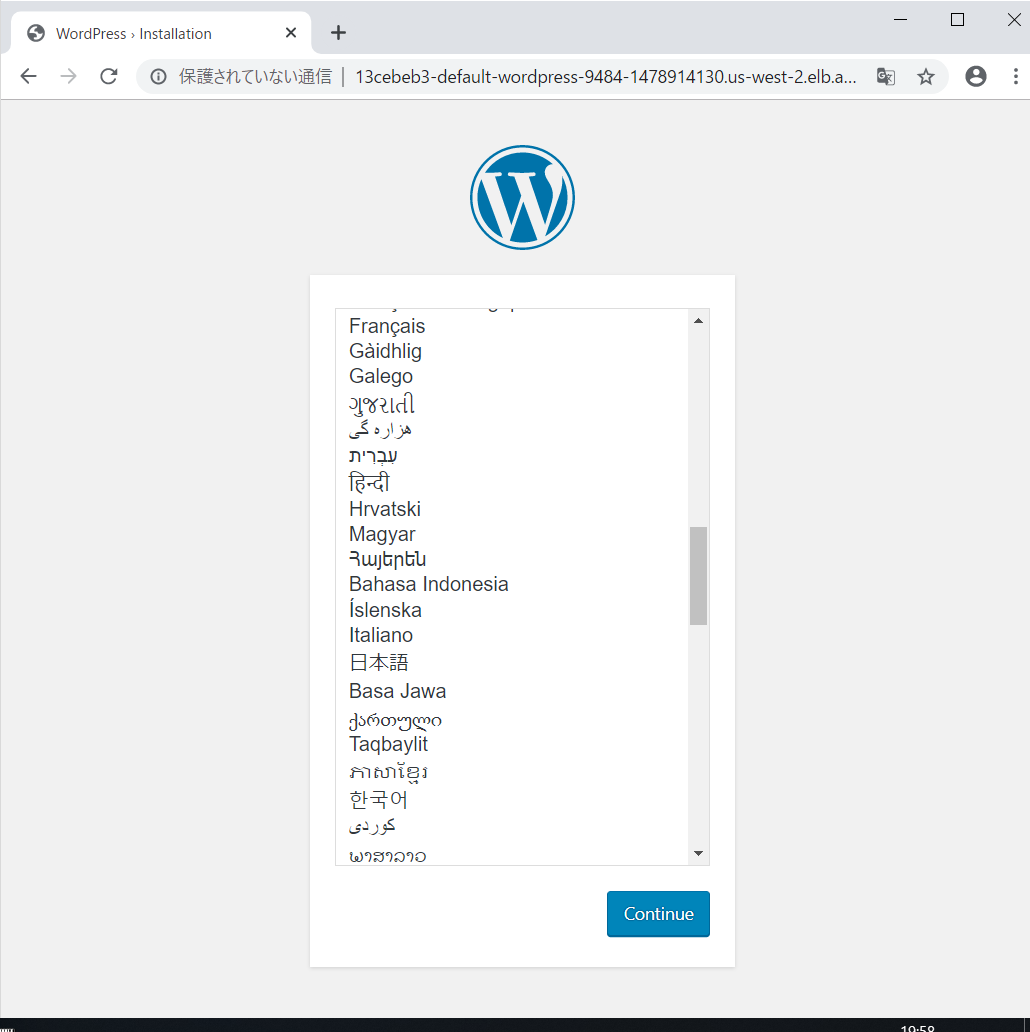

ファイルを配置できることを確認。

In [92]:
!kubectl get pod

NAME                               READY   STATUS    RESTARTS   AGE
efs-provisioner-79db86f4c4-hnnc9   1/1     Running   0          64m
wordpress-75b8c95b57-494fq         1/1     Running   0          19s
wordpress-75b8c95b57-g6zrn         1/1     Running   0          20s


In [103]:
!kubectl exec -it wordpress-75b8c95b57-494fq id

uid=0(root) gid=0(root) groups=0(root),2000


In [104]:
!kubectl exec -it wordpress-75b8c95b57-494fq touch /var/www/html/wp-content/uploads/test.txt

In [105]:
!kubectl exec -it wordpress-75b8c95b57-494fq touch /var/www/html/wp-content/uploads/test2.txt

In [107]:
!kubectl exec -it wordpress-75b8c95b57-494fq echo "test" >> /var/www/html/wp-content/uploads/test3.txt

/bin/sh: 1: cannot create /var/www/html/wp-content/uploads/test3.txt: Directory nonexistent


RuntimeError: Unexpected exit code: 2

In [87]:
!kubectl describe pvc 

Name:          efs
Namespace:     default
StorageClass:  aws-efs
Status:        Bound
Volume:        pvc-fdb54b2e-3dce-11ea-8fb1-06ca8af009de
Labels:        <none>
Annotations:   kubectl.kubernetes.io/last-applied-configuration:
                 {"apiVersion":"v1","kind":"PersistentVolumeClaim","metadata":{"annotations":{"volume.beta.kubernetes.io/storage-class":"aws-efs"},"name":"...
               pv.kubernetes.io/bind-completed: yes
               pv.kubernetes.io/bound-by-controller: yes
               volume.beta.kubernetes.io/storage-class: aws-efs
               volume.beta.kubernetes.io/storage-provisioner: example.com/aws-efs
Finalizers:    [kubernetes.io/pvc-protection]
Capacity:      1Mi
Access Modes:  RWX
VolumeMode:    Filesystem
Events:
  Type       Reason                 Age   From                                                                                       Message
  ----       ------                 ----  ----                                                    

In [88]:
!kubectl describe pod wordpress-7c97d9c456-sr6z4

Name:               wordpress-7c97d9c456-sr6z4
Namespace:          default
Priority:           0
PriorityClassName:  <none>
Node:               ip-10-0-31-122.us-west-2.compute.internal/10.0.31.122
Start Time:         Thu, 23 Jan 2020 11:01:51 +0000
Labels:             app=wordpress
                    pod-template-hash=7c97d9c456
Annotations:        kubernetes.io/psp: eks.privileged
Status:             Running
IP:                 10.0.18.109
Controlled By:      ReplicaSet/wordpress-7c97d9c456
Containers:
  wordpress:
    Container ID:   docker://a086a896e7b78b0d660f3bdda90ee5f36ae659cfb765e640c600967b6a8a0d1e
    Image:          wordpress:4.8-apache
    Image ID:       docker-pullable://wordpress@sha256:6216f64ab88fc51d311e38c7f69ca3f9aaba621492b4f1fa93ddf63093768845
    Port:           80/TCP
    Host Port:      0/TCP
    State:          Running
      Started:      Thu, 23 Jan 2020 11:01:52 +0000
    Ready:          True
    Restart Count:  0
    Environment:
      WORDPRESS_DB_HOST:

In [109]:
!kubectl logs wordpress-75b8c95b57-494fq

WordPress not found in /var/www/html - copying now...
+ ls -A
wp-content
+ sleep 10
Complete! WordPress has been successfully copied to /var/www/html
AH00558: apache2: Could not reliably determine the server's fully qualified domain name, using 10.0.23.39. Set the 'ServerName' directive globally to suppress this message
AH00558: apache2: Could not reliably determine the server's fully qualified domain name, using 10.0.23.39. Set the 'ServerName' directive globally to suppress this message
[Thu Jan 23 11:23:44.202089 2020] [mpm_prefork:notice] [pid 1] AH00163: Apache/2.4.10 (Debian) PHP/5.6.32 configured -- resuming normal operations
[Thu Jan 23 11:23:44.202132 2020] [core:notice] [pid 1] AH00094: Command line: 'apache2 -D FOREGROUND'
10.0.56.173 - - [23/Jan/2020:11:23:55 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.31.122 - - [23/Jan/2020:11:23:55 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.56.173 - - [23/Jan/2020:11:24:10 +0000] "GET / HTTP/1.1

In [120]:
!kubectl get pod

NAME                               READY   STATUS    RESTARTS   AGE
efs-provisioner-79db86f4c4-hnnc9   1/1     Running   0          99m
wordpress-75b8c95b57-494fq         1/1     Running   0          35m
wordpress-75b8c95b57-g6zrn         1/1     Running   0          35m


In [121]:
!kubectl logs wordpress-75b8c95b57-494fq

WordPress not found in /var/www/html - copying now...
+ ls -A
wp-content
+ sleep 10
Complete! WordPress has been successfully copied to /var/www/html
AH00558: apache2: Could not reliably determine the server's fully qualified domain name, using 10.0.23.39. Set the 'ServerName' directive globally to suppress this message
AH00558: apache2: Could not reliably determine the server's fully qualified domain name, using 10.0.23.39. Set the 'ServerName' directive globally to suppress this message
[Thu Jan 23 11:23:44.202089 2020] [mpm_prefork:notice] [pid 1] AH00163: Apache/2.4.10 (Debian) PHP/5.6.32 configured -- resuming normal operations
[Thu Jan 23 11:23:44.202132 2020] [core:notice] [pid 1] AH00094: Command line: 'apache2 -D FOREGROUND'
10.0.56.173 - - [23/Jan/2020:11:23:55 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.31.122 - - [23/Jan/2020:11:23:55 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.56.173 - - [23/Jan/2020:11:24:10 +0000] "GET / HTTP/1.1

10.0.31.122 - - [23/Jan/2020:11:39:11 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.31.122 - - [23/Jan/2020:11:39:13 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.56.173 - - [23/Jan/2020:11:39:13 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.31.122 - - [23/Jan/2020:11:39:26 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.56.173 - - [23/Jan/2020:11:39:41 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.56.173 - - [23/Jan/2020:11:39:43 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.31.122 - - [23/Jan/2020:11:39:56 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.56.173 - - [23/Jan/2020:11:40:11 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.31.122 - - [23/Jan/2020:11:40:13 +0000] "GET / HTTP/1.1" 301 238 "-" "ELB-HealthChecker/2.0"
10.0.31.122 - - [23/Jan/2020:11:40:19 +0000] "GET / HTTP/1.1" 200 53846 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10

いろいろ削除

まずはALBIngressControllerIAMPolicyの削除

In [129]:
ALBPolicyArn = 'arn:aws:iam::565991835156:policy/ALBIngressControllerIAMPolicy'

In [130]:
workerRolearn = 'eksctl-aws-eks-200123-nodegroup-n-NodeInstanceRole-1S46M9PWOP7U1'

In [131]:
!aws iam detach-role-policy \
--policy-arn {ALBPolicyArn} \
--role-name {workerRolearn}

In [132]:
!aws iam delete-policy \
--policy-arn {ALBPolicyArn}

kubectlで作成したオブジェクトの削除

In [133]:
!kubectl delete -f yaml/wordpress-ingress.yaml
!kubectl delete -f yaml/wordpress-service.yaml
!kubectl delete -f yaml/wordpress-deploy.yaml
!kubectl delete -f alb-ingress-controller.yaml
!kubectl delete -f https://raw.githubusercontent.com/kubernetes-sigs/aws-alb-ingress-controller/v1.1.4/docs/examples/rbac-role.yaml
!kubectl delete -f deployment.yaml    

ingress.extensions "wordpress-ingress" deleted
service "wordpress" deleted
deployment.apps "wordpress" deleted
deployment.apps "alb-ingress-controller" deleted
clusterrole.rbac.authorization.k8s.io "alb-ingress-controller" deleted
clusterrolebinding.rbac.authorization.k8s.io "alb-ingress-controller" deleted
serviceaccount "alb-ingress-controller" deleted
serviceaccount "efs-provisioner" deleted
deployment.apps "efs-provisioner" deleted


In [134]:
!kubectl delete -f class.yaml
!kubectl delete -f configmap.yaml
!kubectl delete -f rbac.yaml
!kubectl delete -f deployment.yaml
!kubectl delete -f claim.yaml

storageclass.storage.k8s.io "aws-efs" deleted
configmap "efs-provisioner" deleted
clusterrole.rbac.authorization.k8s.io "efs-provisioner-runner" deleted
clusterrolebinding.rbac.authorization.k8s.io "run-efs-provisioner" deleted
role.rbac.authorization.k8s.io "leader-locking-efs-provisioner" deleted
rolebinding.rbac.authorization.k8s.io "leader-locking-efs-provisioner" deleted
Error from server (NotFound): error when deleting "deployment.yaml": serviceaccounts "efs-provisioner" not found
Error from server (NotFound): error when deleting "deployment.yaml": deployments.apps "efs-provisioner" not found


RuntimeError: Unexpected exit code: 1

クラスタの削除

In [135]:
!eksctl delete cluster \
    --name {clusterName} \
    --wait

[ℹ]  eksctl version 0.13.0
[ℹ]  using region us-west-2
[ℹ]  deleting EKS cluster "aws-eks-200123"
[ℹ]  account is not authorized to use Fargate. Ignoring error
[ℹ]  cleaning up LoadBalancer services
[ℹ]  2 sequential tasks: { delete nodegroup "ng-200123", delete cluster control plane "aws-eks-200123" }
[ℹ]  will delete stack "eksctl-aws-eks-200123-nodegroup-ng-200123"
[ℹ]  waiting for stack "eksctl-aws-eks-200123-nodegroup-ng-200123" to get deleted
[✖]  unexpected status "DELETE_FAILED" while waiting for CloudFormation stack "eksctl-aws-eks-200123-nodegroup-ng-200123"
[ℹ]  fetching stack events in attempt to troubleshoot the root cause of the failure
[✖]  AWS::CloudFormation::Stack/eksctl-aws-eks-200123-nodegroup-ng-200123: DELETE_FAILED – "The following resource(s) failed to delete: [NodeInstanceRole]. "
[✖]  AWS::IAM::Role/NodeInstanceRole: DELETE_FAILED – "Cannot delete entity, must detach all policies first. (Service: AmazonIdentityManagement; Status Code: 409; Error Code: DeleteCo

RuntimeError: Unexpected exit code: 1